# Classifier calibration

For some applications, experts would like to interpret the output of the probabilities that a classifier is providing. Let's take the example of weather forecasting and specifically prediction of severe rainfall classification. If an event declare a 80% probability to have a severe rainfall, on 100 events with such particular weather, 80 of them had a severe rainfall outcome while 20 of them did not.

Thus, it happens that classifiers do not provide a probabilities that translate into such interpretation: these classifiers are not calibrated. When such interpretations are required, one should make sure that classifiers are calibrated and if not, should calibrate them.

In this notebook, we will investigate how to check if a classifier or not is calibrated and how to calibrate one.

## Presentation of our dataset

Let's load the dataset where we will illustrate our problem.

In [1]:
import sklearn

sklearn.set_config(display="diagram")

In [2]:
import pandas as pd

data = pd.read_csv("../datasets/weather.csv", parse_dates=["Date"])
data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


This dataset contains information about weather forecast. We will modify this dataset such that our target will be the `"Rainfall"` column. We will create a classification problem by thresholding the target to get to category: >50 mm that will be severe rainfall and <50 mm that will not be a severe rainfall.

In addition, we will drop the `"RainToday"` and `"RainTomorrow"` features that are the link with the original classification problem.

In [3]:
import numpy as np

target_name = "Rainfall"
data = data.dropna(axis="index", subset=[target_name])
X = data.drop(columns=["RainToday", "RainTomorrow", target_name])
y = (data[target_name] > 50).astype(np.int64)

Now let's have a look at the available features and their types

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142199 entries, 0 to 145459
Data columns (total 20 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           142199 non-null  datetime64[ns]
 1   Location       142199 non-null  object        
 2   MinTemp        141712 non-null  float64       
 3   MaxTemp        141729 non-null  float64       
 4   Evaporation    81711 non-null   float64       
 5   Sunshine       74379 non-null   float64       
 6   WindGustDir    132474 non-null  object        
 7   WindGustSpeed  132534 non-null  float64       
 8   WindDir9am     132410 non-null  object        
 9   WindDir3pm     138400 non-null  object        
 10  WindSpeed9am   141108 non-null  float64       
 11  WindSpeed3pm   139552 non-null  float64       
 12  Humidity9am    140645 non-null  float64       
 13  Humidity3pm    138569 non-null  float64       
 14  Pressure9am    128259 non-null  float64       
 15  

So we can see that we will need to:

- encode the `"Date"` feature;
- encode the column the `object` columns using an `OrdinalEncoder`;
- let the numerical features as-is;
- impute the missing values with a constant.

In addition, let's check the distributionof the target.

In [5]:
y.value_counts()

0    141400
1       799
Name: Rainfall, dtype: int64

Thus, we can observe that the problem is imbalanced.

## Our machine learning model

We use a `BalancedRandomForestClassifier` on this problem. First, let's start to create a preprocessor.

### Date parser

Let's create a small function that would encode the date into three different features for the day, month, and year.

In [6]:
def date_parser(X):
    X = X.copy()
    X["day"] = X["Date"].dt.day
    X["month"] = X["Date"].dt.month
    X["year"] = X["Date"].dt.year
    return X.drop(columns=["Date"])

### Data preprocessor

Now, let's create a preprocessor to encode the categorical columns and let the numerical columns as-is. We will use `make_column_selector` based on the dtype to select the right columns.

In [7]:
from sklearn.compose import make_column_selector

numerical_columns = make_column_selector(dtype_exclude=[object, "datetime"])(X)
categorical_columns = make_column_selector(dtype_include=object)(X)

Now, we will use a `ColumnTransformer` to encode and impute the missing data.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

preprocessor = ColumnTransformer(
    transformers=[
        (
            "categorical",
            make_pipeline(
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                SimpleImputer(strategy="constant", fill_value=-1),
            ),
            categorical_columns,
        ),
        (
            "numerical",
            SimpleImputer(strategy="constant", fill_value=-1),
            numerical_columns,
        )
    ],
)
preprocessor

ColumnTransformer(transformers=[('categorical',
                                 Pipeline(steps=[('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('simpleimputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'))]),
                                 ['Location', 'WindGustDir', 'WindDir9am',
                                  'WindDir3pm']),
                                ('numerical',
                                 SimpleImputer(fill_value=-1,
                                               strategy='constant'),
                                 ['MinTemp', 'MaxTemp', 'Evaporation',
                                  'Sunshine', 'WindGustSpeed', 'WindSpeed9am',
                                  'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
                                  'Pressure9am', 'Pressure3pm', 'Cloud9am',
                                  'Cloud3pm', 'Temp9am', 'Temp3pm'])])

### Full model

Now that we have our preprocessor, we can create our entire model finshing by a `BalancedRandomForestClassifier`.

In [9]:
from sklearn.preprocessing import FunctionTransformer
from imblearn.ensemble import BalancedRandomForestClassifier

model = make_pipeline(
    FunctionTransformer(date_parser),
    preprocessor,
    BalancedRandomForestClassifier(n_jobs=-1, random_state=0),
)
model

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function date_parser at 0x158539f70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Locatio...
                                                 ('numerical',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Evaporation', 'Sunshine',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(n_jobs=-1, random_state=0))])

We can now evaluate our model using cross-validation. Since we deal with time series, we will use a `TimeSeriesSplit` cross-validation scheme.

In addition, we will use several metrics: balanced accuracy, average precision, and brier loss.

In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, balanced_accuracy_score, average_precision_score, brier_score_loss

scoring = {
    "balanced_accuracy": make_scorer(balanced_accuracy_score),
    "average_precision": make_scorer(average_precision_score, needs_proba=True),
    "brier_score": make_scorer(
        brier_score_loss, greater_is_better=False, needs_proba=True,
    ),
}
cv = TimeSeriesSplit()

We are finally ready to run our cross-validation.

In [11]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(
    model, X, y, cv=cv, scoring=scoring, n_jobs=-1,
)

In [12]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_balanced_accuracy,test_average_precision,test_brier_score
0,1.579969,0.514580,0.839420,0.139180,-0.109866
1,2.764772,0.250829,0.767202,0.024706,-0.099576
2,3.576741,0.190916,0.807447,0.107282,-0.088014
3,4.407301,0.538416,0.863462,0.174819,-0.080819
4,6.731789,0.167283,0.869446,0.168652,-0.093083


In [13]:
cv_results.mean()

fit_time                  3.812114
score_time                0.332405
test_balanced_accuracy    0.829395
test_average_precision    0.122928
test_brier_score         -0.094272
dtype: float64

### A note about the Brier score

The Brier score (that is indeed a loss) measures the if the probability predicted by a classifier are accurate. An uncalibrated classifier will result in an higher Brier score than a well calibrated classifier.

## About classifier calibration

Now, that we have our model, we will show how to check if it is calibrated. Let's first make a single train-test split and train our classifier.

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, random_state=0
)

In [15]:
model.fit(X_train, y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function date_parser at 0x158539f70>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ordinalencoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(fill_value=-1,
                                                                                 strategy='constant'))]),
                                                  ['Locatio...
                                                 ('numerical',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='constant'),
                                                  ['MinTemp', 'MaxTemp',
                                                   'Evaporation', 'Sunshine',
                                                   'WindGustSpeed',
                                                   'WindSpeed9am',
                                                   'WindSpeed3pm',
                                                   'Humidity9am', 'Humidity3pm',
                                                   'Pressure9am', 'Pressure3pm',
                                                   'Cloud9am', 'Cloud3pm',
                                                   'Temp9am', 'Temp3pm'])])),
                ('balancedrandomforestclassifier',
                 BalancedRandomForestClassifier(n_jobs=-1, random_state=0))])

We can use the `CalibrationDisplay` that will plot the fraction of positive against the mean predicted probability. For a calibrated classifier, we would expect the fraction of positive to be aligned wiht the mean predicted probability, such that is follow our original explanation. Let's check if our classifier is calibrated.

In [16]:
import seaborn as sns
sns.set_context("poster")

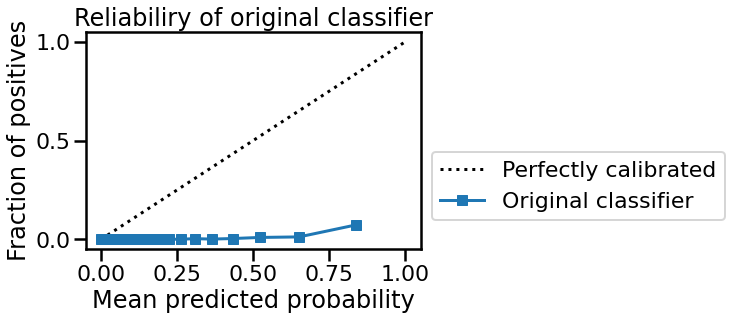

In [26]:
from sklearn.calibration import CalibrationDisplay

display = CalibrationDisplay.from_estimator(
    model, X_test, y_test, strategy="quantile", n_bins=20,
    name="Original classifier", markersize=10,
)
display.ax_.legend(loc="best", bbox_to_anchor=(1, 0.5))
_ = display.ax_.set_title("Reliabiliry of original classifier")

We observe that our classifier is not well calibrated since it does not follow the diagonal.

When a model is not calibrated, it can be either:

- overconfident: the predicted probability will be higher than the fraction of positives, or
- underconfident: the predicted probability will be lower than the fraction of positives.

Here, our model is clearly overconfident. A classifier can be recalibrated using `CalibratedClassifierCV`. This classifier will use a calibrator that will fit a function to map the probabilities of the uncalibrated classifier to the true predictions.

In [18]:
from sklearn.calibration import CalibratedClassifierCV

model_calibrated = CalibratedClassifierCV(
    model, method="isotonic",
)
model_calibrated

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('functiontransformer',
                                                       FunctionTransformer(func=<function date_parser at 0x158539f70>)),
                                                      ('columntransformer',
                                                       ColumnTransformer(transformers=[('categorical',
                                                                                        Pipeline(steps=[('ordinalencoder',
                                                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                        unknown_value=-1)),
                                                                                                        ('simpleimputer',
                                                                                                         SimpleImputer(fill_valu...
                                                                                        SimpleImputer(fill_value=-1,
                                                                                                      strategy='constant'),
                                                                                        ['MinTemp',
                                                                                         'MaxTemp',
                                                                                         'Evaporation',
                                                                                         'Sunshine',
                                                                                         'WindGustSpeed',
                                                                                         'WindSpeed9am',
                                                                                         'WindSpeed3pm',
                                                                                         'Humidity9am',
                                                                                         'Humidity3pm',
                                                                                         'Pressure9am',
                                                                                         'Pressure3pm',
                                                                                         'Cloud9am',
                                                                                         'Cloud3pm',
                                                                                         'Temp9am',
                                                                                         'Temp3pm'])])),
                                                      ('balancedrandomforestclassifier',
                                                       BalancedRandomForestClassifier(n_jobs=-1,
                                                                                      random_state=0))]),
                       method='isotonic')

Now, we can evaluate our model with cross-validation.

In [19]:
cv_results = cross_validate(
    model_calibrated, X, y, cv=cv, scoring=scoring, n_jobs=-1,
)

In [31]:
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_balanced_accuracy,test_average_precision,test_brier_score
0,6.167604,2.248713,0.5,0.128863,-0.006857
1,11.017486,1.089218,0.5,0.044497,-0.002675
2,14.120957,0.923373,0.5,0.099340,-0.010340
3,16.957580,2.680314,0.5,0.117855,-0.001151
4,24.632815,0.821166,0.5,0.206617,-0.003962


In [32]:
cv_results.mean()

fit_time                  14.579288
score_time                 1.552557
test_balanced_accuracy     0.500000
test_average_precision     0.119435
test_brier_score          -0.004997
dtype: float64

We observe that while the balanced accuracy goes down, the average precision remains more or less stable. More importantly the Brier score is much smaller meaning that our classifier is better calibrated. We can check now the reliability diagram.

In [33]:
model_calibrated.fit(X_train, y_train)

CalibratedClassifierCV(base_estimator=Pipeline(steps=[('functiontransformer',
                                                       FunctionTransformer(func=<function date_parser at 0x158539f70>)),
                                                      ('columntransformer',
                                                       ColumnTransformer(transformers=[('categorical',
                                                                                        Pipeline(steps=[('ordinalencoder',
                                                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                                        unknown_value=-1)),
                                                                                                        ('simpleimputer',
                                                                                                         SimpleImputer(fill_valu...
                                                                                        SimpleImputer(fill_value=-1,
                                                                                                      strategy='constant'),
                                                                                        ['MinTemp',
                                                                                         'MaxTemp',
                                                                                         'Evaporation',
                                                                                         'Sunshine',
                                                                                         'WindGustSpeed',
                                                                                         'WindSpeed9am',
                                                                                         'WindSpeed3pm',
                                                                                         'Humidity9am',
                                                                                         'Humidity3pm',
                                                                                         'Pressure9am',
                                                                                         'Pressure3pm',
                                                                                         'Cloud9am',
                                                                                         'Cloud3pm',
                                                                                         'Temp9am',
                                                                                         'Temp3pm'])])),
                                                      ('balancedrandomforestclassifier',
                                                       BalancedRandomForestClassifier(n_jobs=-1,
                                                                                      random_state=0))]),
                       method='isotonic')

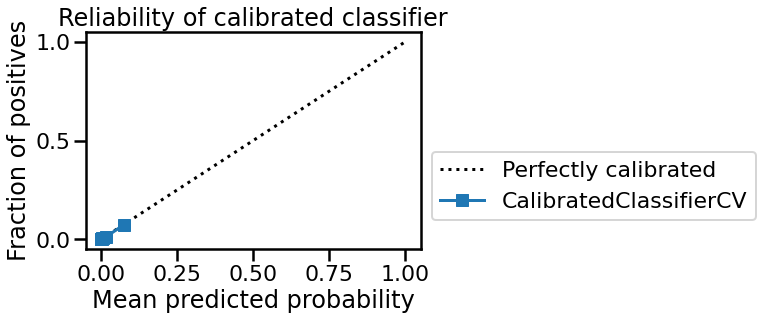

In [34]:
display = CalibrationDisplay.from_estimator(
    model_calibrated, X_test, y_test, strategy="quantile", n_bins=20
)
display.ax_.legend(loc="best", bbox_to_anchor=(1, 0.5))
_ = display.ax_.set_title("Reliability of calibrated classifier")

We observe that our classifier follow the diagonal. Since we are using quantile and most probability are in the lower probability, we don't have data point above 10%. We could force the binning to use a uniform sampling. However, we might have very few points and thus a lot of variance then.

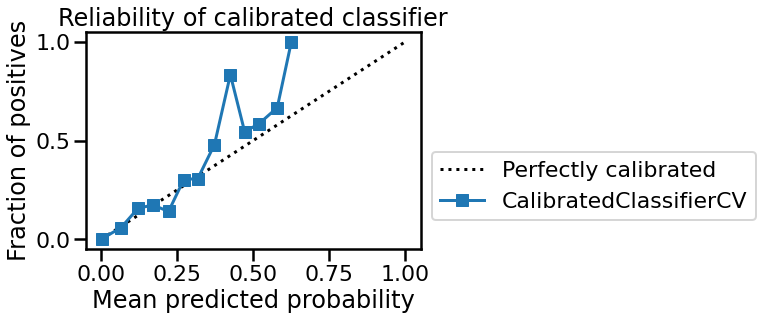

In [40]:
display = CalibrationDisplay.from_estimator(
    model_calibrated, X_test, y_test, strategy="uniform", n_bins=20
)
display.ax_.legend(loc="best", bbox_to_anchor=(1, 0.5))
_ = display.ax_.set_title("Reliability of calibrated classifier")